A vector can be thought of in two ways:
- In computer science: an array of real (floating point) numbers
- In math: an element of a finite dimensional vector space

The mathematical definition is more general and abstract: vector spaces support addition of vectors and multiplication by scalars, but there is no notion of "length", "angle", "dot product" etc.

A refinement of the concept of a vector space, known as an inner product space, adds these features. And by identifying a _basis_ of the vector space, we can retrieve the corresponding arrays of real numbers.

Similarly a matrix can be thought of as:
- A 2d array of real (floating point) numbers
- A linear map from one vector space to another

In machine learning, particularly neural networks, it's worth keeping both of these interpretations in mind. Some layers are linear and others are not; the nonlinear layers often operate "elementwise", whereas for the linear layers each element does not necessarily have a clear interpretation and we need to think in terms of arbitrary vectors.

The final few layers of a language transformer model are the unembedding. The job of these layers is to turn a vector (in the "model space") into a probability distribution over tokens.

In the case of gpt2-small, the model space is 768-dimensional and the token vocabulary size is 50257.

The unembedding consists of:
- a learned unembedding _matrix_ (768x50257)
- a learned _bias vector_, which outputs _logits_
- a fixed _softmax layer_, which outputs _probabilities_

Let's go in reverse and look at the softmax layer first. We'll use a toy example for illustration with a very small vocabulary, but the concepts generalize to a larger vocabulary.

In [1]:
import torch

# Our example vocabulary
vocab = ['cat','dog','pig','squirrel','the','of','and']

# The number of words in the vocabulary (or the "dimension" of the logit and probability spaces)
d_V = len(vocab)
print(f"Vocab size = {d_V}")

# Generate a random vector of logits (the input to softmax). The generator just makes sure this returns the same answer each time
generator = torch.Generator()
generator.manual_seed(12345)
logits = torch.normal(mean=0.0, std=1.0, size=(d_V,), generator=generator)

print('Logits =', logits)

# See which word has the greatest logit. This will be the "most likely" in the probability distribution
# We print both the index and the corresponding string token
most_likely = torch.argmax(logits).item()
print(f'Most likely =', most_likely, vocab[most_likely])

# Now put it through softmax to obtain the probabilities
probs = torch.nn.functional.softmax(logits, dim=0)

# Enumerate the probability vector, showing corresponding tokens
def print_example_probs(probs):
    print('Probs =', probs)
    for i in range(d_V):
        print('    ', f'{vocab[i]:10}', probs[i].item())
print_example_probs(probs)

Vocab size = 7
Logits = tensor([ 1.4271, -1.8701, -1.1962, -2.0440, -0.4560, -1.4295, -0.7175])
Most likely = 0 cat
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])
     cat        0.6815164685249329
     dog        0.025206468999385834
     pig        0.049450863152742386
     squirrel   0.021183840930461884
     the        0.10366861522197723
     of         0.03916327282786369
     and        0.07981050759553909


Softmax has some interesting properties. In particular:
- Adding a uniform value to each logit leaves the output of softmax unchanged. Softmax only cares about how much things are bigger and smaller than each other, not their actual values
- Scaling the vector up (multiplying by a real number >1) will increase the certainty, i.e. make the most likely value more likely
- Scaling the vector down (multiplying by a real number <1) will have the opposite effect, making the distribution flatter.

In [2]:
print('Original:')
print(f'Probs =', torch.nn.functional.softmax(logits, dim=0))
print()
print('Adding 17 elementwise (this comes out the same):')
print(f'Probs =', torch.nn.functional.softmax(logits + 17, dim=0))
print()
print('Multiplying by 2 (makes it more certain):')
print(f'Probs =', torch.nn.functional.softmax(logits * 2, dim=0))
print()
print('Multiplying by 0.5 (makes it less certain):')
print(f'Probs =', torch.nn.functional.softmax(logits * 0.5, dim=0))

Original:
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])

Adding 17 elementwise (this comes out the same):
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])

Multiplying by 2 (makes it more certain):
Probs = tensor([9.5442e-01, 1.3056e-03, 5.0250e-03, 9.2214e-04, 2.2084e-02, 3.1517e-03,
        1.3089e-02])

Multiplying by 0.5 (makes it less certain):
Probs = tensor([0.3832, 0.0737, 0.1032, 0.0676, 0.1494, 0.0918, 0.1311])


In [3]:
print("Note that if the softmax layer is given a vector of zeros, it will output equal probability for every token")
print("This is ok in our toy example, but in the real dictionary a lot of the tokens are very rare/complete garbage.")
print("We don't want to output equal probability for those.")
zeros = torch.zeros((d_V,))
print(f'Probs =', torch.nn.functional.softmax(zeros))

Note that if the softmax layer is given a vector of zeros, it will output equal probability for every token
This is ok in our toy example, but in the real dictionary a lot of the tokens are very rare/complete garbage.
We don't want to output equal probability for those.
Probs = tensor([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429])


/tmp/ipykernel_29679/2753053289.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f'Probs =', torch.nn.functional.softmax(zeros))


Now that we understand softmax, let's look at the previous layers.

Because some tokens are a lot more probable than others (in general), it helps to have a "bias layer" that adds the approximate token commonness to each token, before the softmax is applied. This can be "overridden" in some sense - given a sufficiently large vector identifying one particular token, that token will still win even if the bias layer is against it.

In [4]:
bias = torch.tensor([1.0, 1.0, 0.5, -0.5, 2.0, 2.0, 2.0])

print("Original (without bias vector):")
print_example_probs(torch.nn.functional.softmax(logits, dim=0))

print()
print("With bias vector added:")
print_example_probs(torch.nn.functional.softmax(logits + bias, dim=0))

print()
print("If the original vector is large enough, it can overcome the bias and the squirrel wins")
big_squirrel_logits = torch.tensor([0, 0, 0, 7, 0, 0, 0])
print_example_probs(torch.nn.functional.softmax(big_squirrel_logits + bias, dim=0))

Original (without bias vector):
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])
     cat        0.6815164685249329
     dog        0.025206468999385834
     pig        0.049450863152742386
     squirrel   0.021183840930461884
     the        0.10366861522197723
     of         0.03916327282786369
     and        0.07981050759553909

With bias vector added:
Probs = tensor([0.5061, 0.0187, 0.0223, 0.0035, 0.2093, 0.0791, 0.1611])
     cat        0.506083607673645
     dog        0.01871793530881405
     pig        0.022272685542702675
     squirrel   0.003510014619678259
     the        0.2092607021331787
     of         0.07905318588018417
     and        0.1611018180847168

If the original vector is large enough, it can overcome the bias and the squirrel wins
Probs = tensor([0.0039, 0.0039, 0.0024, 0.9579, 0.0106, 0.0106, 0.0106])
     cat        0.0039146095514297485
     dog        0.0039146095514297485
     pig        0.0023743310011923313
     squirrel   0.

It's important not to forget the bias vector is there. But, we're not going to focus on it here.

Instead, we'll be looking at the weights matrix. This can be thought of as a linear map from the model's internal vector space to the token logit space.

In this artificial example, we'll be pretending the model space is two dimensional. This is unrealistic but will help with visualizations.

torch.Size([2, 7])


Text(tensor(0.8000), tensor(1.), '(example)')

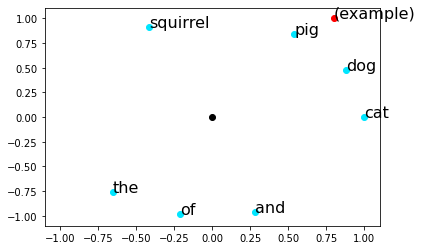

In [5]:
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

ts = [0, 0.5, 1, 2, 4, 4.5, 5]

# The weights matrix
M_to_V = torch.tensor([[math.cos(t), math.sin(t)] for t in ts]).T
print(M_to_V.shape)

# An example vector
example_vector = torch.tensor([0.8, 1.0])

ax = plt.gca()
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

plt.scatter([0], [0], color=(0,0,0))
plt.scatter(M_to_V[0,:], M_to_V[1,:], color=(0,0.9,1))
for t in range(d_V):
    plt.text(M_to_V[0,t], M_to_V[1,t], vocab[t], size=16)

plt.scatter([example_vector[0]], [example_vector[1]], color=(1,0,0))
plt.text(example_vector[0], example_vector[1], '(example)', size=16)

When you dot-product it with all of the weight matrix's vectors, you'll get larger numbers for the ones that it's closer to.

In [6]:
logits = torch.matmul(example_vector, M_to_V)

print('Logits =', probs)
for i in range(d_V):
    print('    ', f'{vocab[i]:10}', logits[i].item())

Logits = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])
     cat        0.800000011920929
     dog        1.1814916133880615
     pig        1.2737127542495728
     squirrel   0.5763798952102661
     the        -1.2797174453735352
     of         -1.1461668014526367
     and        -0.7319945096969604


As expected, dog and pig come out ahead. The bias vector would then be applied, messing things about a bit, and then softmax would be applied.

By making the vector large enough, and point in the right direction, we can pick out any of these words and make it very likely. This allows for a very basic aspect of language model behaviour: sometimes being very certain about the next word.

But note that our 2d space has fewer dimensions that the number of words we can represent. We are making good use of the spaciousness of our space here; the unembedding vectors are not necessarily orthogonal to each other.

One oversimplification in this example: all of the unembedding vectors are shown as being the same length. This is not the case in the real unembedding matrix.

Next, let's look at a real unembedding matrix.

In [7]:
import torch
from easy_transformer import EasyTransformer

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

# Convenience function for decoding token
decode = model.tokenizer.decode

# Convenience function for encoding token
def encode(t):
    global model
    result = model.tokenizer.encode(t)
    if len(result) != 1:
        raise Exception(f"Not a single token: {t}")
    return result[0]

unembed = model.unembed.W_U.data
d_M = model.cfg.d_model
d_V = model.cfg.d_vocab

print(unembed.shape, d_M, d_V)

Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cuda
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu
torch.Size([768, 50257]) 768 50257


We'll use a PCA dimensionality reduction to visualize the unembedding matrix, and label a few of the points.

PCA is a linear way to reduce a high number of dimensions (in this case the dimension of our model space, 768) down to a smaller number (in this case 2).

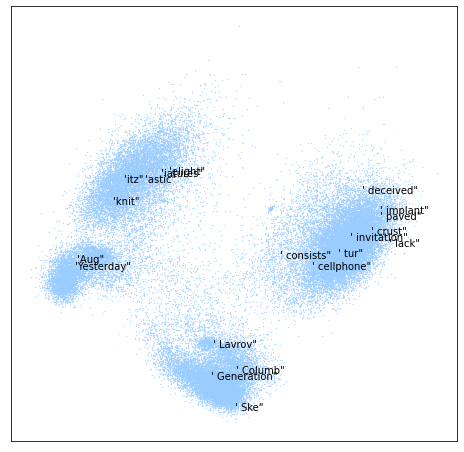

In [8]:
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [8, 8]

# The unembedding matrix is transposed because we need to turn the column vectors into rows
xy = PCA(n_components=2).fit_transform(unembed.T)
fig,ax = plt.subplots(1,1)
ax.scatter(xy[:,0], xy[:,1], s=0.1, color=(0.6, 0.8, 1))


import random
random.seed(12344)
tokens = random.sample(range(d_V), k=20)
for t in tokens:
    ax.text(xy[t,0], xy[t,1], "'" + decode(t) + '"')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

You can see there are separate blobs for lowercase words, words starting with uppercase, and parts of words.

One question that came up earlier was about the lengths (i.e. the norm) of the row vectors in the unembedding matrix. Some are longer than other. But why? Does it have to do with how common the token is?

Let's see how the vector lengths compares with the values in the bias vector.

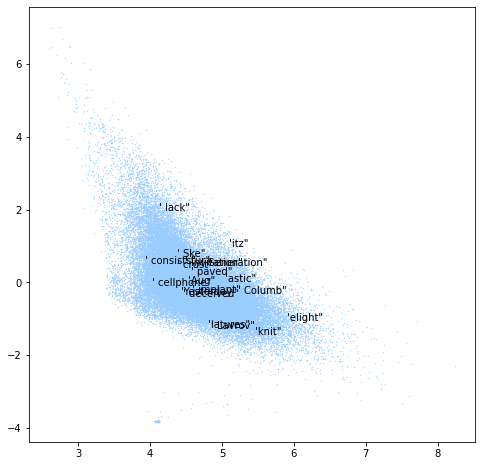

In [9]:
plt.rcParams['figure.figsize'] = [8, 8]
fig,ax = plt.subplots(1,1)
bias = model.unembed.b_U.data
norms = torch.linalg.vector_norm(unembed, dim=0)
ax.scatter(norms, bias, s=0.1, color=(0.6, 0.8, 1))
for t in tokens:
    ax.text(norms[t], bias[t], "'" + decode(t) + '"')


There's maybe a bit of correlation there, but nothing spectacular. Note, however, that the norm assumes an inner product space - which we maybe shouldn't be assuming. In particular, some dimensions of the vector space may be more "stretched out" or more "significant" than others, which will distort our norm calculation.


So far we have focused on unembedding - mapping from the model space to the vocab space. But is there an opposite concept of "embedding"?

In fact, there are at least two.

The first is the embedding matrix in the model itself. This defines, as words are read in from the prompt, how they are embedded. But there's nothing saying this has to correspond in any way to the unembedding. Usually we would expect it to - if it sees a word once it might be expected to reproduce it again later, and this implies a relationship between embedding and unembedding. But it's not guaranteed.

In particular, remember the model is expected to generate the _next_ word in the sequence. So if we (somewhat unrealistically) imagine a simplified transformer with zero layers, just consisting of embedding and unembedding, we wouldn't expect them to be inverses of each other.

It's also not mathematically possible for them to be inverses, because they are not square matrices. There is however a concept of a "pseudo-inverse", also known as the Moore-Penrose inverse. This is an "approximate" inverse that also works for non-square matrices. We can apply this to the unembedding matrix to get a pseudo-embedding. It might be somewhat artificial, but I've found it useful to play around with.

First let's see how the model embedding and unembedding compare. We'll do this by embedding a token, unembedding it, and seeing if our token comes out "top".

In [10]:
tokens = [' cat', ' dog', ' pig', ' leaves', ' the']
embed = model.embed.W_E.data

def print_gpt2_logits(logits, n=10):
    values = [(v.item(),i) for i,v in enumerate(logits)]
    values.sort(reverse=True)
    for v,t in values[:n]:
        print('    ', f'{decode(t):20}', v)

for tok in tokens:
    t = encode(tok)
    v = embed[t,:]
    u = torch.matmul(v, unembed)
    print(f"'{tok}'")
    print_gpt2_logits(u)

' cat'
      cat                 10.138724327087402
      cats                7.158444881439209
     Cat                  6.515383243560791
      Cat                 6.233247756958008
     cat                  6.153323173522949
      Cats                5.525265216827393
      corrid              5.3981032371521
      kitten              5.353123188018799
      mosqu               5.327042102813721
     cats                 5.298948287963867
' dog'
      dog                 9.772444725036621
      dogs                8.121519088745117
      canine              7.295004367828369
     Dog                  6.845795631408691
     dog                  6.764692783355713
      Dog                 6.643533229827881
      Dogs                6.561904430389404
      puppy               6.396916389465332
     dogs                 5.521637439727783
      puppies             5.519559860229492
' pig'
      pig                 11.74259090423584
      pigs                7.804096698760986
      Pig   

You can see it does pretty well, but the stop word " the" does not embed as itself.

We can do better than this though. We can make a vector "purer" by _subtracting_ parts of it that we don't like.

In [15]:
def subtract_tok(v0, tok1):
    t1 = encode(tok1)
    v1 = embed[t1,:]
    #print(v1)
    u0 = torch.matmul(v0, unembed)
    u1 = torch.matmul(v1, unembed)
    mult = u0[t1] / u1[t1]
    return v0 - mult * v1

def print_gpt2_model_vec(v, n=10):
    print_gpt2_logits(torch.matmul(v, unembed), n=n)

print(' cat')
v_cat = embed[encode(' cat'),:]
print_gpt2_model_vec(v_cat)

print(' cat minus corrid')
v = subtract_tok(v_cat, ' corrid')
print_gpt2_model_vec(v)

print(' cat minus corrid minus dog')
v = subtract_tok(v, ' dog')
print_gpt2_model_vec(v)

print(' leaves')
v_leaves = embed[encode(' leaves'),:]
print_gpt2_model_vec(v_leaves)

print(' leaves minus left')
v = subtract_tok(v_leaves, ' left')
print_gpt2_model_vec(v)

print(' leaves minus foliage')
v = subtract_tok(v_leaves, ' foliage')
print_gpt2_model_vec(v)




 cat
      cat                 10.138724327087402
      cats                7.158444881439209
     Cat                  6.515383243560791
      Cat                 6.233247756958008
     cat                  6.153323173522949
      Cats                5.525265216827393
      corrid              5.3981032371521
      kitten              5.353123188018799
      mosqu               5.327042102813721
     cats                 5.298948287963867
 cat minus corrid
      cat                 10.311352729797363
      cats                7.200417518615723
      Cat                 6.533332347869873
     Cat                  6.457385540008545
     cat                  6.113367557525635
      Cats                5.678449630737305
      kitten              5.155793190002441
     cats                 5.12518310546875
      kittens             4.723011493682861
      CAT                 4.621988296508789
 cat minus corrid minus dog
      cat                 8.664301872253418
      Cat                 